In [1]:
import os
import time
import numpy as np
import pickle
import gc
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

In [2]:
CUDA = 'cuda:0'
DEVICE = torch.device(CUDA if torch.cuda.is_available() else "cpu")
data_path = '/home/deepak/CS_MRI_codes_simulation/MRI_MCCAI_data/training_gt_split_2'
model_save_path = '/home/deepak/CS_MRI_codes_simulation/MRI_MCCAI_data/'

In [3]:
#Architecture build
#subclassing 

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
#         self.dense0 = nn.Linear(1024, 4*4*256)
#         self.bn0 = nn.BatchNorm1d(4*4*256)
        self.tconv0 = nn.ConvTranspose2d(256, 256, 4, 1, padding=0, bias=False)
        self.bn0 = nn.BatchNorm2d(256)

        self.tconv1 = nn.ConvTranspose2d(256, 192, 4, 2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(192)

        self.tconv2 = nn.ConvTranspose2d(192, 128, 4, 2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64 , 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.tconv4 = nn.ConvTranspose2d(64, 32, 4, 2, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(32)
        
        self.tconv5 = nn.ConvTranspose2d(32, 16 , 4, 2, padding=1,bias=False)
        self.bn5 = nn.BatchNorm2d(16)
        
        self.tconv6 = nn.ConvTranspose2d(16, 1, 4, 2, padding=1, bias=False)
        
        

    def forward(self, x): 
        x = F.relu(self.bn0(self.tconv0(x)))
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        img = torch.tanh(self.tconv6(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 4, 2, 1,bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 192, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(192)
        
        self.conv6 = nn.Conv2d(192, 256, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(256)

#         self.conv6_flatten = nn.Sequential(nn.Conv2d(192, 256, 5, 2, 2, bias=False),
#                                           nn.BatchNorm2d(256),
#                                           nn.LeakyReLU(True),
#                                           nn.Flatten()
#                                           )
        
#         self.dense7 = nn.Linear(4096,1024)
#         self.bn7 = nn.BatchNorm1d(1024)
        

        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn6(self.conv6(x)), 0.1, inplace=True)
        return x

class DHead(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(256, 256, 4, 1, 0, bias=False)# will resutl in 1X1X256
        self.bn1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(256, 1, 1, 1, 0, bias=False)

        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)
        output = torch.sigmoid(self.conv2(x))
        return output

class QHead(nn.Module):
    def __init__(self,CODE_DIM):
        super().__init__()
        
        self.conv1 = nn.Conv2d(256, 128, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128 ,CODE_DIM, 2, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        code_cap = torch.sigmoid(self.conv2(x)) #activation changed to sigmoid(disc_codes)

        return code_cap
    
class Projector(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5= nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(128, 192, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(192)
        
        self.conv7 = nn.Conv2d(192, 256, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        latent_est = self.conv7(x)
        
        return latent_est


In [4]:
#functions for loading the data as a randomized batch
def load_data(file_name):
    with open(file_name,'rb') as f:
        data = pickle.load(f)
    f.close()
    gc.collect()
    return data

def batch_wise_split(n_files, batch_size):
    X = np.arange(n_files)
    random_file_choice = np.random.choice(X, 1)
    file_name = 'train_gt_%04d.pickle'% (random_file_choice+1)
    #print(random_file_choice+1)
    data_loaded = load_data(os.path.join(data_path, file_name))
    #from data loaded select any 32 samples(slices)
    slice_sel_array = np.arange(len(data_loaded))
    slice_sel = np.random.choice(slice_sel_array, batch_size, replace = False)
    #print(slice_sel)
    X_train = []
    for i in slice_sel:
        X_train.append(data_loaded[i])
    return X_train

In [5]:
# construction of the latent variable (Returns a batch of latent variable) 
def make_cont_codes(n_code_vec, n_samples):
    cont_codes = np.random.uniform(-1,1,size = (n_samples, n_code_vec))
    return cont_codes
def make_disc_codes(n_disc_code_vec, n_samples):
    cat = np.random.randint(0, n_disc_code_vec, n_samples)
    cat_codes = np.zeros((n_samples, n_disc_code_vec))
    for i in range(n_samples):
        cat_codes[i,cat[i]] = np.int(1)  
    return cat_codes
def generate_latent_points(latent_dim, n_code_vec, n_samples):
    z_latent = np.random.randn(latent_dim*n_samples)
    z_latent = z_latent.reshape(n_samples, latent_dim)
    cont_codes = make_cont_codes(n_code_vec, n_samples)
    #disc_codes = make_disc_codes(n_disc_code_vec, n_samples)
    z_input = np.hstack((z_latent,cont_codes))
    z_inps = [torch.Tensor(z_input).unsqueeze(2).unsqueeze(3), torch.tensor(cont_codes, dtype = torch.float64)]
    return z_inps
    

In [6]:
z,_ = generate_latent_points(48, 16, 32)
print(z[1])

tensor([[[-1.5201e+00]],

        [[ 4.3935e-01]],

        [[-3.4586e-01]],

        [[ 9.6719e-01]],

        [[-1.2643e-01]],

        [[ 1.9074e+00]],

        [[ 6.6063e-01]],

        [[ 1.0181e+00]],

        [[-2.1736e-01]],

        [[ 8.7846e-01]],

        [[-4.2633e-01]],

        [[-3.0070e-01]],

        [[ 6.3518e-03]],

        [[-1.4210e-01]],

        [[-7.3818e-01]],

        [[-1.9638e+00]],

        [[-1.4046e+00]],

        [[-1.0451e+00]],

        [[-6.8938e-01]],

        [[-8.0300e-04]],

        [[-2.1056e-01]],

        [[ 2.1123e-02]],

        [[ 3.5627e-01]],

        [[ 3.1683e-01]],

        [[ 1.7682e+00]],

        [[ 6.2966e-03]],

        [[-7.3120e-01]],

        [[ 7.0270e-01]],

        [[-1.5743e-01]],

        [[-6.1294e-01]],

        [[-1.2843e+00]],

        [[ 1.8553e+00]],

        [[ 1.4266e+00]],

        [[-8.2189e-02]],

        [[-1.7171e+00]],

        [[-4.1282e-02]],

        [[-1.1440e+00]],

        [[-3.2413e-01]],

        [[ 6

In [7]:
# def smooth_fake_labels(y):
#     y = y + 0.01 #(np.random.random(y.shape)*0.3)
#     return y
# def smooth_real_labels(y):
#     y = y - 0.1 #(np.random.random(y.shape)*0.3)
#     return y

In [8]:
def noisy_labels(y, p_flip):
    n_select = int(p_flip * y.shape[0])
    flip_index = np.random.choice([i for i in range(y.shape[0])],size = n_select)
    y[flip_index] = 1 - y[flip_index]
    return y

In [9]:
# def add_noise(X):
#     noise = np.random.normal(0, 0.1, X[0,0,:,:].shape)
#     X = X + noise
#     return X 

In [10]:
def generate_real_samples(n_files, n_samples): 
    # loads and lables n_samples of ground truth data in in a random order 
    X = np.reshape(np.array(batch_wise_split(n_files, n_samples)),(n_samples,-1,256,256))
    y = np.ones((n_samples, 1))
    y = noisy_labels(y, 3/32)
    #y = smooth_real_labels(y)
    return torch.Tensor(X), torch.Tensor(y)

def generate_fake_samples(generator, z_input, n_samples):
    images = generator(z_input)                  
    y = np.zeros((n_samples, 1))
    y = noisy_labels(y, 1/32)
    #y = smooth_fake_labels(y)
    return images, torch.Tensor(y)

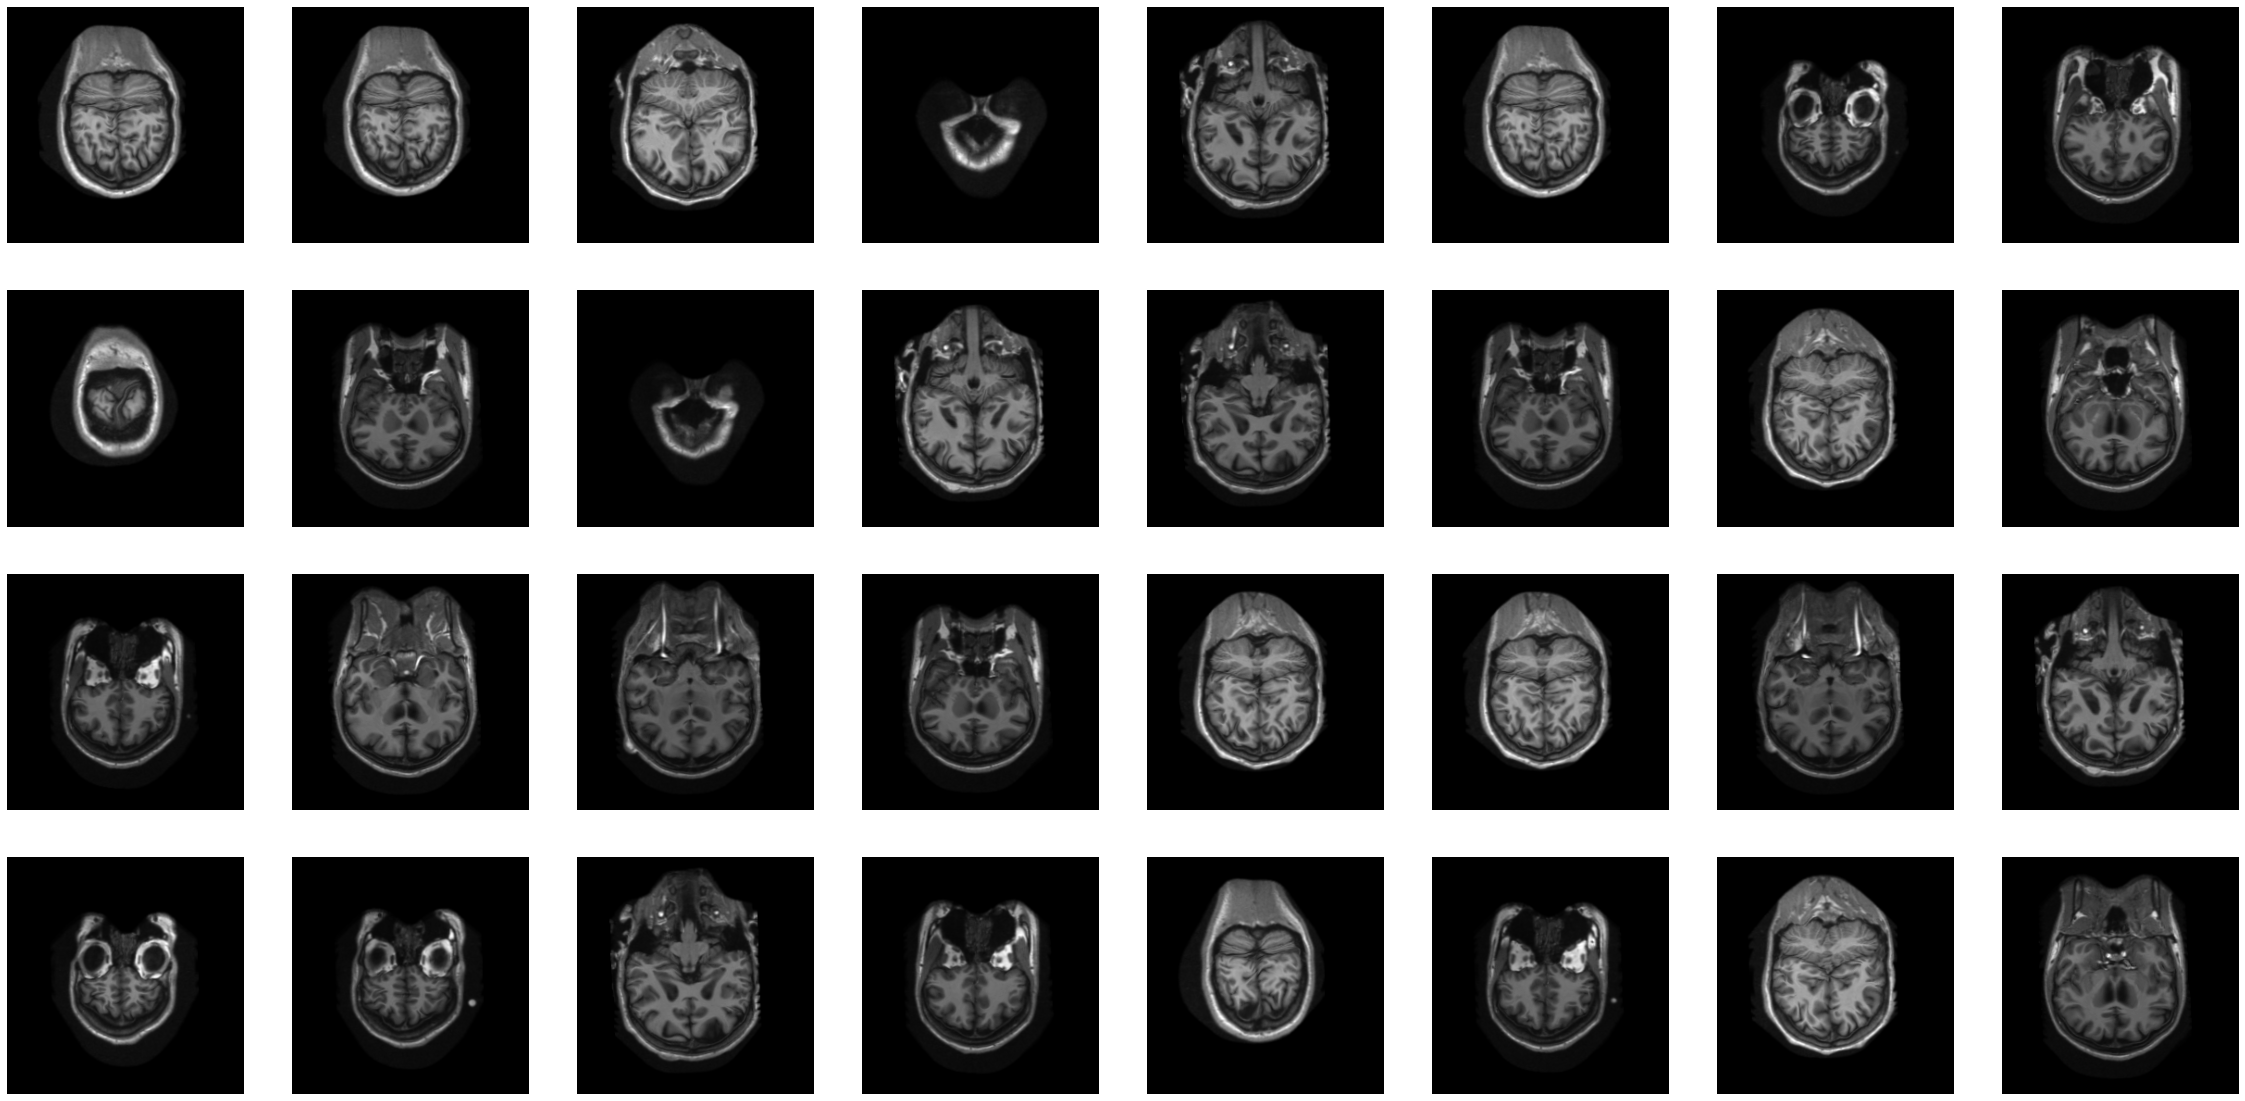

In [11]:
X, _ = generate_real_samples(100, 32)
fig = plt.figure(figsize=(40,20))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(X[i][0,:,:], cmap = 'gray')
plt.show()

In [12]:
#weights init function
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d or type(m) == nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d or type(m) == nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1.0, 0.05)
        nn.init.constant_(m.bias.data, 0)
        
def weights_init_codes(m):
    if(type(m) == nn.Linear):
        nn.init.constant_(m.weight.data, 0)


In [13]:
# Initialise the network.
g_model = Generator().to(DEVICE)
g_model.apply(weights_init)
#print(g_model)

d_model = Discriminator().to(DEVICE)
d_model.apply(weights_init)
#print(d_model)

netD = DHead().to(DEVICE)
netD.apply(weights_init)
#print(netD)

netQ = QHead(64).to(DEVICE)
netQ.apply(weights_init)
#print(netQ)

proj_model = Projector().to(DEVICE)
proj_model.apply(weights_init)
#print(proj_model)

Projector(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn6): B

In [14]:
from torchsummary import summary
summary(g_model,(256,1,1))
summary(d_model,(1,256,256))
summary(netD,(256,4,4))
summary(netQ,(256,4,4))
summary(proj_model,(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 256, 4, 4]             512
   ConvTranspose2d-3            [-1, 192, 8, 8]         786,432
       BatchNorm2d-4            [-1, 192, 8, 8]             384
   ConvTranspose2d-5          [-1, 128, 16, 16]         393,216
       BatchNorm2d-6          [-1, 128, 16, 16]             256
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,072
       BatchNorm2d-8           [-1, 64, 32, 32]             128
   ConvTranspose2d-9           [-1, 32, 64, 64]          32,768
      BatchNorm2d-10           [-1, 32, 64, 64]              64
  ConvTranspose2d-11         [-1, 16, 128, 128]           8,192
      BatchNorm2d-12         [-1, 16, 128, 128]              32
  ConvTranspose2d-13          [-1, 1, 256, 256]             256
Total params: 2,401,888
Trainable param

In [15]:
import torch.optim as optim

In [16]:
# loss functions and optimizer instantiation

D_loss = nn.BCELoss()
Q_loss = nn.MSELoss()

D_optim = optim.Adam([{'params': d_model.parameters()}, {'params': netD.parameters()}], lr=0.000001, betas=(0.5,0.999))
G_optim = optim.Adam([{'params':g_model.parameters()}, {'params':netQ.parameters()}], lr=0.000001, betas=(0.5,0.999))

In [17]:
#Training the network

In [18]:
# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []
Q_losses = []

In [19]:
num_epochs = 10
save_epoch = 69
batch_size = 32
n_batches = 30
n_files = 100
latent_dim = 256-64
n_code_vec =64

In [20]:
print(D_optim)
print(G_optim)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0
)


In [48]:
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs %d: Batch Size %d:' % (num_epochs, batch_size))
print("-"*25)

-------------------------
Starting Training Loop...

Epochs 10: Batch Size 32:
-------------------------


In [302]:
start_time = time.time()
iters = 0
min_loss = 1.5

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    for i in range(n_batches):
        # Get half batch size
        half_batch_size = int(batch_size/2)
        # Transfer data tensor to GPU/CPU (DEVICE)
        real_data, real_labels = generate_real_samples(n_files, half_batch_size)
        real_data = real_data.to(DEVICE)
        real_labels = real_labels.view(-1).to(DEVICE)

        # Updating discriminator and DHead
        D_optim.zero_grad()
        output1 = d_model(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = D_loss(probs_real, real_labels)
        
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        noise, disc_codes = generate_latent_points(latent_dim, n_code_vec, half_batch_size)
        noise = noise.to(DEVICE)
        disc_codes = disc_codes.to(DEVICE)
        fake_data, fake_labels = generate_fake_samples(g_model, noise ,half_batch_size)
        fake_data = fake_data.to(DEVICE)
        fake_labels = fake_labels.view(-1).to(DEVICE)
        output2 = d_model(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = D_loss(probs_fake, fake_labels)
        
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        total_D_loss = loss_real + loss_fake
        # Update parameters
        D_optim.step()

        
        
        # Updating Generator and QHead
        G_optim.zero_grad()
        
        noise_g, disc_codes_g = generate_latent_points(latent_dim, n_code_vec, batch_size)
        noise_g = noise_g.to(DEVICE)
        disc_codes_g = disc_codes_g.to(DEVICE)
        fake_data_g, _ = generate_fake_samples(g_model, noise_g, batch_size)
        fake_data_g = fake_data_g.to(DEVICE)
        invert_labels = torch.ones(batch_size,).to(DEVICE)
        # Fake data treated as real.
        output = d_model(fake_data_g)
        probs_fake = netD(output).view(-1)
        gen_loss = D_loss(probs_fake, invert_labels)

        q_output = netQ(output).squeeze(2).squeeze(2).to(dtype=torch.float64)
        target = disc_codes_g #(disc_codes_g == 1).nonzero(as_tuple=True)[1]
        q_loss = Q_loss(q_output, target)
        
        # Net loss for generator.
        G_loss = gen_loss + q_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        G_optim.step()
        

        # Check progress of training.
        if i != 0 and i%15 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_Q: %.4f'% (epoch+1, num_epochs, i, n_batches, total_D_loss.item(), gen_loss.item(), q_loss.item()))

        # Save the losses for plotting.
        G_losses.append(gen_loss.item())
        Q_losses.append(q_loss.item())
        D_losses.append(total_D_loss.item())

        iters += 1
          #minimum generator loss maintain
        if(gen_loss < min_loss or iters==300):
            min_loss = gen_loss
            torch.save({
            'netG' : g_model.state_dict(),
            'discriminator' : d_model.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'D_optim' : D_optim.state_dict(),
            'G_optim' : G_optim.state_dict(),
            'D_losses': D_losses,
            'G_losses': G_losses,
            'Q_losses': Q_losses
            }, os.path.join(model_save_path,'checkpoint_model_aconv4ks_mod_latent_C_9_4_%04d_d0_000001_g0_000001.pickle'%iters)) 

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    

    
#     # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
#     with torch.no_grad():
#         gen_data = g_model(noise).detach().cpu()
#     img_list.append(vutils.make_grid(gen_data, nrow=8, padding=0, normalize=False))

#     # Generate image to check performance of generator.
#     if((epoch+1) == 1 or (epoch+1) == save_epoch):
#         with torch.no_grad():
#             gen_data = g_model(noise).detach().cpu()
#         plt.figure(figsize=(4, 8))
#         plt.axis("off")
#         plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=8, padding=0, normalize=False), (1,2,0)))
#         plt.savefig("Epoch_%d" %(epoch+1))
#         plt.close('all')

[1/10][15/30]	Loss_D: 1.5305	Loss_G: 1.0852	Loss_Q: 0.3300
Time taken for Epoch 1: 10.54s
[2/10][15/30]	Loss_D: 1.4946	Loss_G: 1.0636	Loss_Q: 0.3301
Time taken for Epoch 2: 10.21s
[3/10][15/30]	Loss_D: 1.2351	Loss_G: 1.1194	Loss_Q: 0.3303
Time taken for Epoch 3: 10.19s
[4/10][15/30]	Loss_D: 0.7180	Loss_G: 1.1946	Loss_Q: 0.3232
Time taken for Epoch 4: 10.12s
[5/10][15/30]	Loss_D: 0.8589	Loss_G: 1.0865	Loss_Q: 0.3293
Time taken for Epoch 5: 10.03s
[6/10][15/30]	Loss_D: 0.9561	Loss_G: 1.0901	Loss_Q: 0.3411
Time taken for Epoch 6: 10.08s
[7/10][15/30]	Loss_D: 1.3559	Loss_G: 1.1243	Loss_Q: 0.3286
Time taken for Epoch 7: 10.06s
[8/10][15/30]	Loss_D: 1.0963	Loss_G: 1.0860	Loss_Q: 0.3301
Time taken for Epoch 8: 10.03s
[9/10][15/30]	Loss_D: 1.4632	Loss_G: 1.0339	Loss_Q: 0.3279
Time taken for Epoch 9: 10.06s
[10/10][15/30]	Loss_D: 1.2692	Loss_G: 1.0260	Loss_Q: 0.3325
Time taken for Epoch 10: 10.09s


In [ ]:
training_time = time.time() - start_time
print("-"*50)


print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

In [20]:
checkpoint = torch.load(os.path.join(model_save_path,'checkpoint_model_aconv4ks_mod_latent_C_9_3_0055_d0_000001_g0_000001.pickle'))
g_model.load_state_dict(checkpoint['netG'])
d_model.load_state_dict(checkpoint['discriminator'])
netD.load_state_dict(checkpoint['netD'])
netQ.load_state_dict(checkpoint['netQ'])                 
D_optim.load_state_dict(checkpoint['D_optim'])
G_optim.load_state_dict(checkpoint['G_optim'])
D_losses = checkpoint['D_losses'] 
G_losses = checkpoint['G_losses']
Q_losses = checkpoint['Q_losses']
# g_model.eval()
# d_model.eval()
# netD.eval()
# netQ.eval()

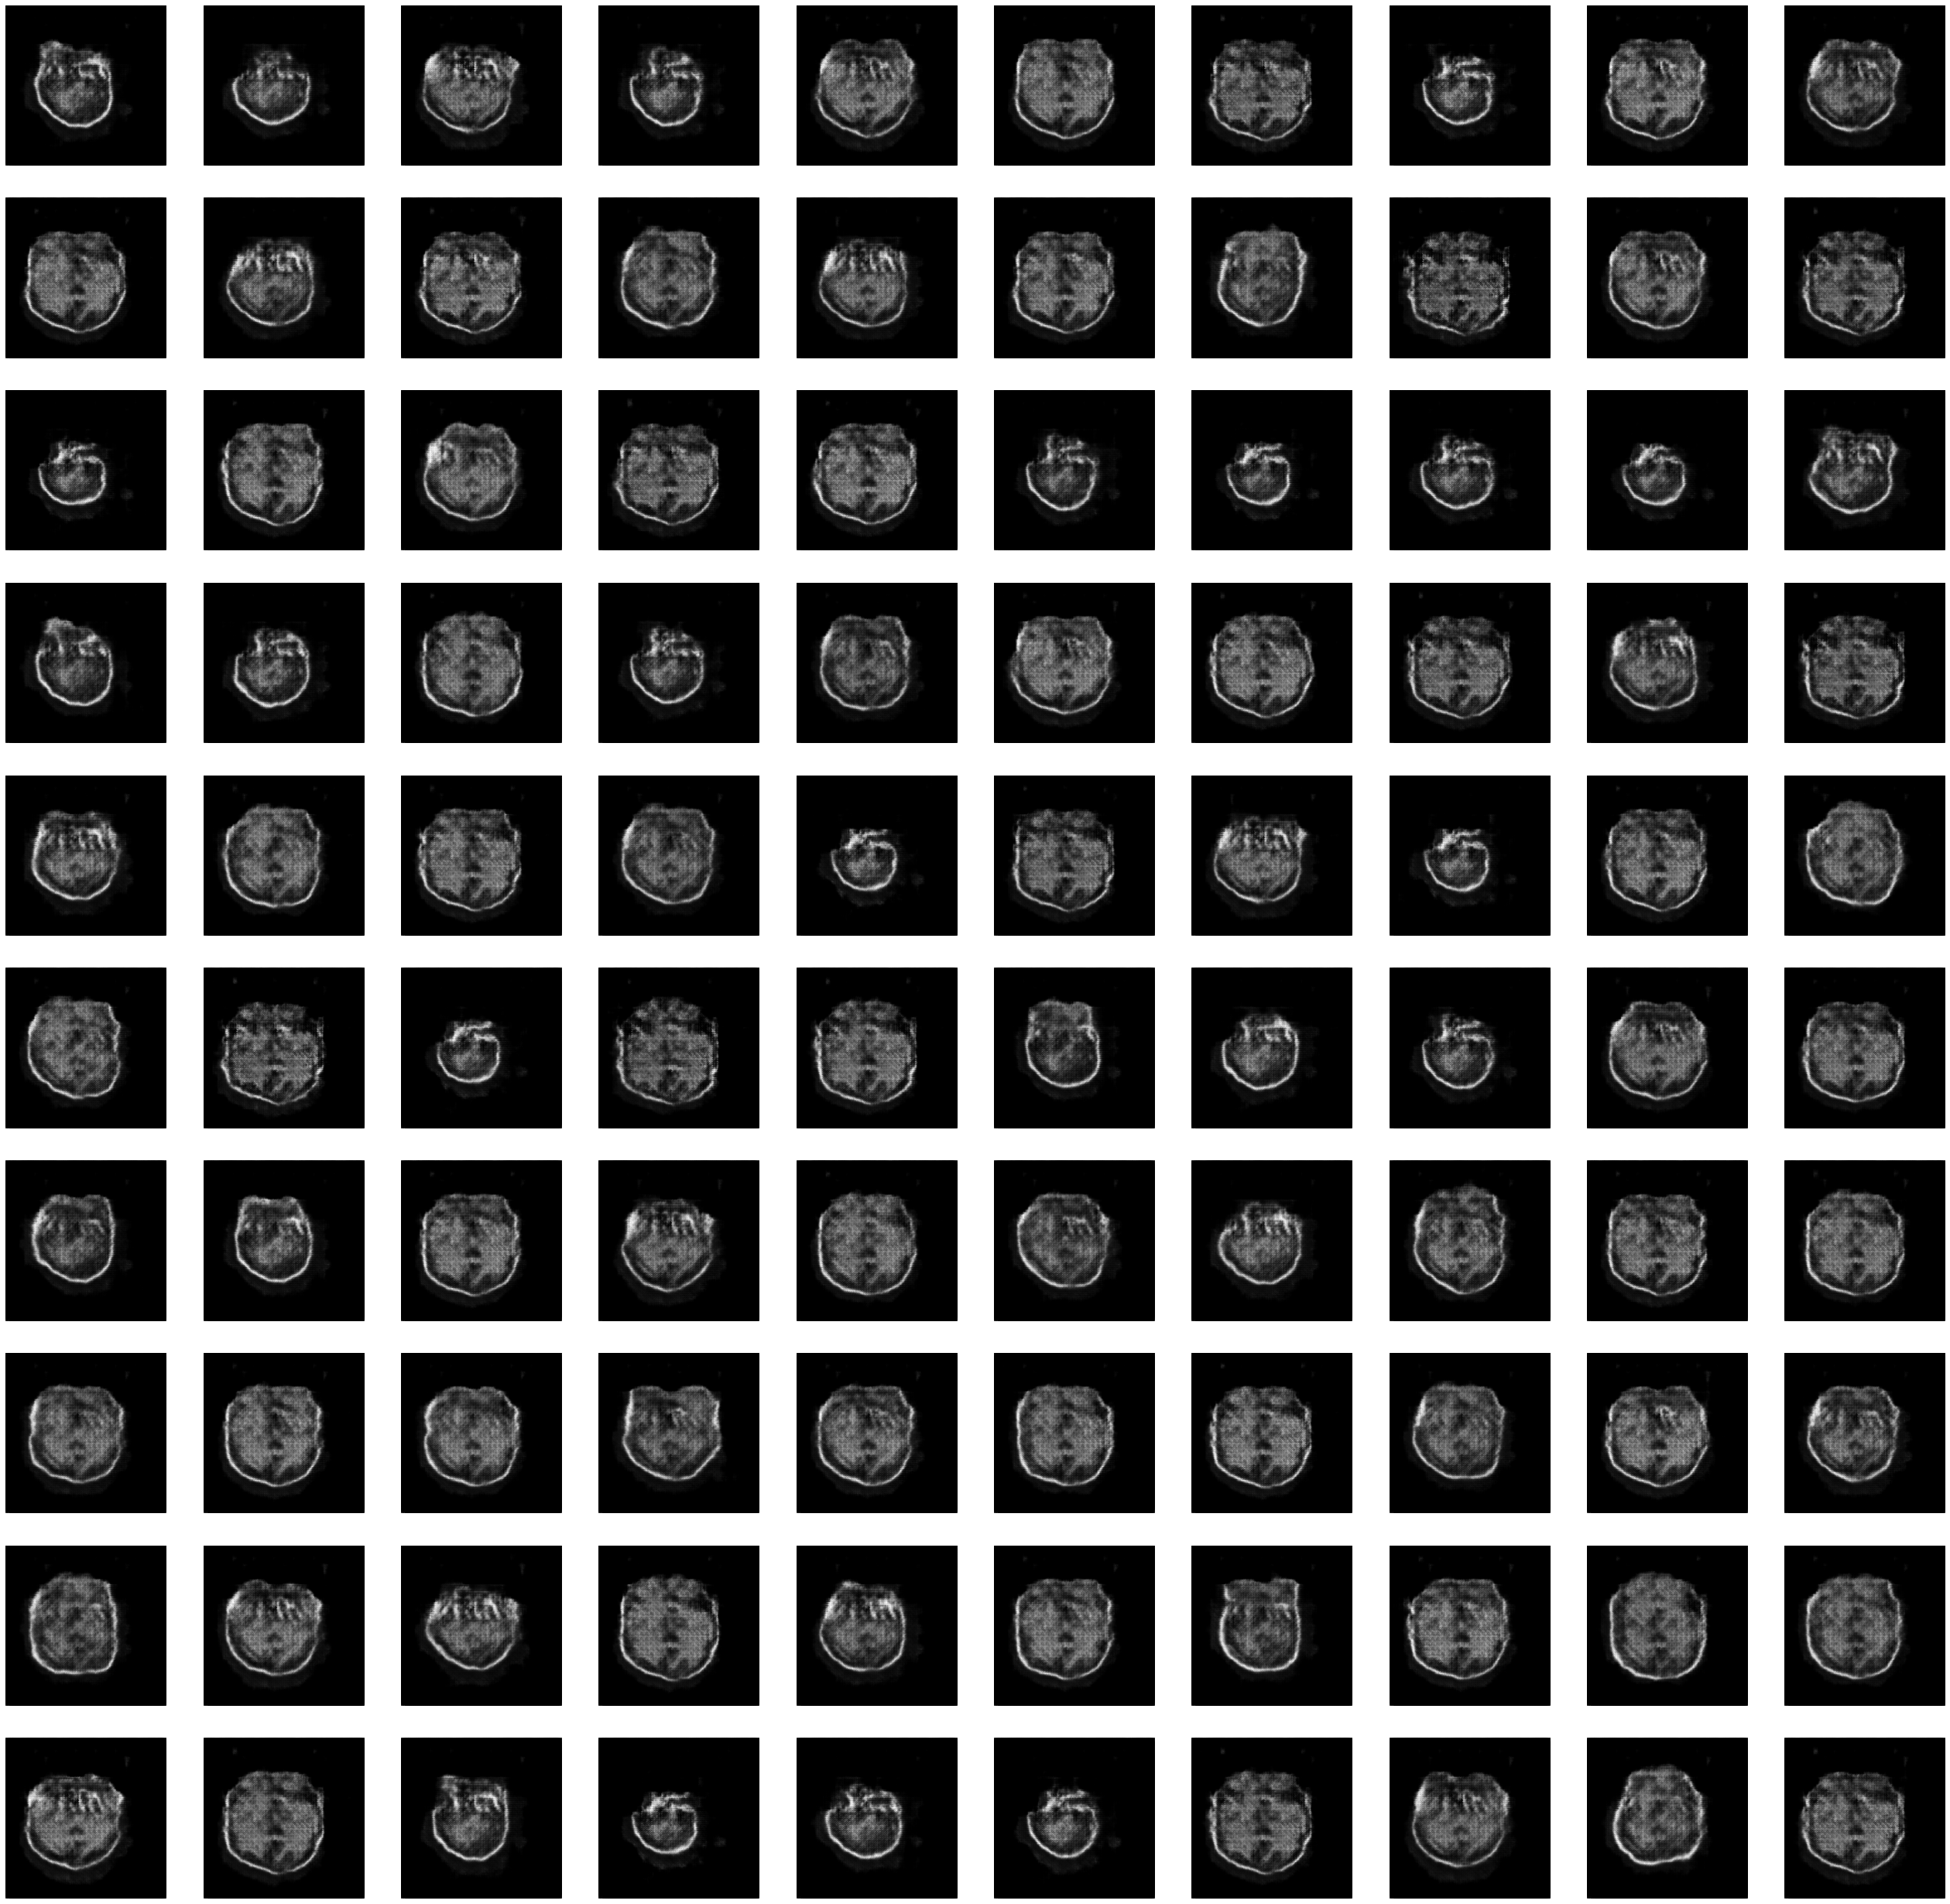

In [21]:
batch_size = 100
noise, cont_codes = generate_latent_points(latent_dim, n_code_vec, batch_size)
noise = noise.to(DEVICE)
cont_codes = cont_codes.to(DEVICE)
fake_data, _ = generate_fake_samples(g_model, noise, batch_size)
fake_data = fake_data.to(DEVICE)
fig = plt.figure(figsize=(45,45))
for i in range(batch_size):
    
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(np.array(fake_data.detach().cpu())[i][0,:,:],cmap = 'gray')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

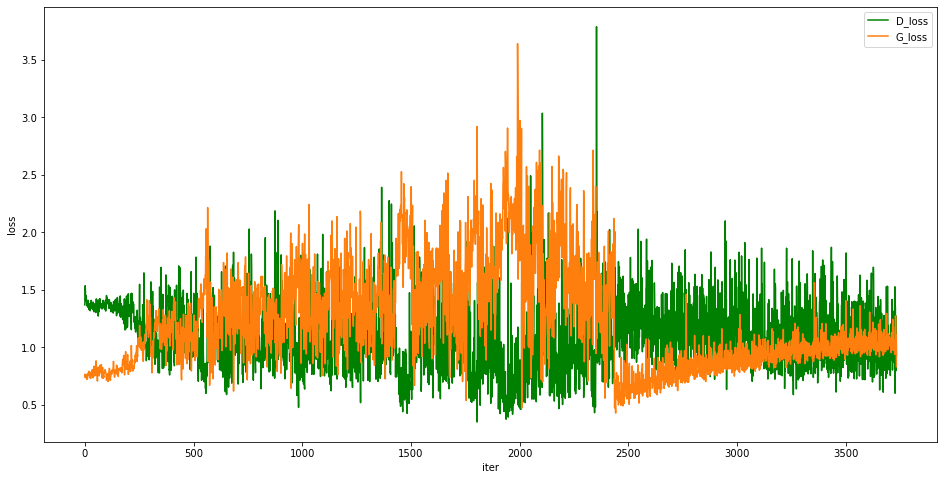

In [22]:
steps = range(len(D_losses))
y_1 = np.array(D_losses)
y_2 = np.array(G_losses)
fig = plt.figure(figsize=(16,8))
plt.plot(steps,y_1,'g')
plt.plot(steps, y_2, 'C1')
plt.legend(['D_loss','G_loss'], loc = 'best')
plt.xlabel('iter')
plt.ylabel('loss')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

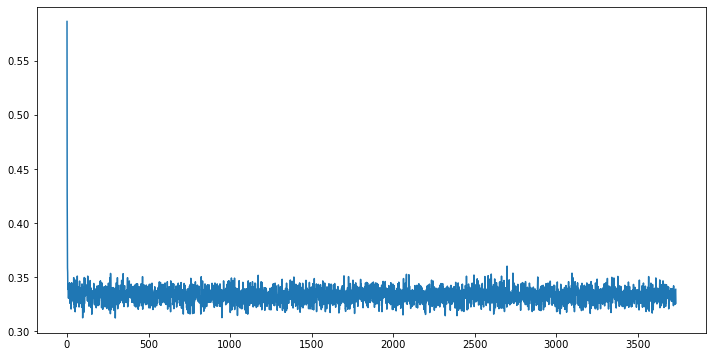

In [23]:
fig = plt.figure(figsize=(12,6))
y = np.array(Q_losses)
plt.plot(steps,y)

plt.show

In [ ]:
# def make_disc_codes_lat_test(n_disc_code_vec, n_samples):
#     cat = np.repeat(np.random.randint(0, n_disc_code_vec),n_samples)
#     cat_codes = np.zeros((n_samples, n_disc_code_vec))
#     for i in range(n_samples):
#         cat_codes[i,cat[i]] = np.int(1)  
#     return cat_codes
# def generate_latent_points_lat_test(latent_dim, n_disc_code_vec, n_samples):
#     z_latent = np.random.randn(latent_dim*n_samples)
#     z_latent = z_latent.reshape(n_samples, latent_dim)
# #     cont_codes = make_cont_codes(n_code_vec, n_samples)
#     disc_codes = make_disc_codes(n_disc_code_vec, n_samples)
#     z_input = np.hstack((z_latent,disc_codes))
#     return [torch.Tensor(z_input), torch.tensor(disc_codes, dtype = torch.long)]
    

In [ ]:
# training of the projector network

In [24]:
P_loss = nn.MSELoss()

In [26]:
P_optim = optim.Adam([{'params':proj_model.parameters()}], lr=0.0001)

In [27]:
Proj_losses = []
n_epochs_proj = 100
save_epoch_proj = 60
n_batches_proj = 30

In [32]:
for epoch in range(n_epochs_proj):
    epoch_start_time = time.time()

    for i in range(n_batches_proj):
        
        P_optim.zero_grad()
        
        real_data, real_labels = generate_real_samples(n_files, batch_size)
        real_data = real_data.to(DEVICE)
        #add_noise = torch.randn(real_data.shape).to(DEVICE)
        inp = real_data #+ add_noise
        
        output = proj_model(inp)
        
        fake_data_g, _ = generate_fake_samples(g_model, output, batch_size)
        fake_data_g = fake_data_g.to(DEVICE)
        
        proj_loss = P_loss(fake_data_g, inp)
        
        # Calculate gradients.
        proj_loss.backward()
        # Update parameters.
        P_optim.step()

        # Check progress of training.
        if i != 0 and i%5 == 0:
            print('[%d/%d][%d/%d]\tLoss_P: %.4f'% (epoch+1, n_epochs_proj, i, n_batches_proj, proj_loss.item()))

        # Save the losses for plotting.
        Proj_losses.append(proj_loss.item())


    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    

[1/70][5/30]	Loss_P: 0.0288
[1/70][10/30]	Loss_P: 0.0166
[1/70][15/30]	Loss_P: 0.0257
[1/70][20/30]	Loss_P: 0.0245
[1/70][25/30]	Loss_P: 0.0240
Time taken for Epoch 1: 12.31s
[2/70][5/30]	Loss_P: 0.0193
[2/70][10/30]	Loss_P: 0.0258
[2/70][15/30]	Loss_P: 0.0309
[2/70][20/30]	Loss_P: 0.0202
[2/70][25/30]	Loss_P: 0.0439
Time taken for Epoch 2: 12.22s
[3/70][5/30]	Loss_P: 0.0182
[3/70][10/30]	Loss_P: 0.0206
[3/70][15/30]	Loss_P: 0.0251
[3/70][20/30]	Loss_P: 0.0184
[3/70][25/30]	Loss_P: 0.0262
Time taken for Epoch 3: 12.24s
[4/70][5/30]	Loss_P: 0.0212
[4/70][10/30]	Loss_P: 0.0287
[4/70][15/30]	Loss_P: 0.0271
[4/70][20/30]	Loss_P: 0.0245
[4/70][25/30]	Loss_P: 0.0314
Time taken for Epoch 4: 12.28s
[5/70][5/30]	Loss_P: 0.0191
[5/70][10/30]	Loss_P: 0.0271
[5/70][15/30]	Loss_P: 0.0216
[5/70][20/30]	Loss_P: 0.0270
[5/70][25/30]	Loss_P: 0.0276
Time taken for Epoch 5: 12.34s
[6/70][5/30]	Loss_P: 0.0384
[6/70][10/30]	Loss_P: 0.0273
[6/70][15/30]	Loss_P: 0.0255
[6/70][20/30]	Loss_P: 0.0196
[6/70][25/

[46/70][25/30]	Loss_P: 0.0202
Time taken for Epoch 46: 12.47s
[47/70][5/30]	Loss_P: 0.0198
[47/70][10/30]	Loss_P: 0.0231
[47/70][15/30]	Loss_P: 0.0180
[47/70][20/30]	Loss_P: 0.0294
[47/70][25/30]	Loss_P: 0.0214
Time taken for Epoch 47: 12.48s
[48/70][5/30]	Loss_P: 0.0271
[48/70][10/30]	Loss_P: 0.0177
[48/70][15/30]	Loss_P: 0.0276
[48/70][20/30]	Loss_P: 0.0203
[48/70][25/30]	Loss_P: 0.0270
Time taken for Epoch 48: 12.47s
[49/70][5/30]	Loss_P: 0.0185
[49/70][10/30]	Loss_P: 0.0218
[49/70][15/30]	Loss_P: 0.0260
[49/70][20/30]	Loss_P: 0.0266
[49/70][25/30]	Loss_P: 0.0277
Time taken for Epoch 49: 12.47s
[50/70][5/30]	Loss_P: 0.0210
[50/70][10/30]	Loss_P: 0.0188
[50/70][15/30]	Loss_P: 0.0215
[50/70][20/30]	Loss_P: 0.0226
[50/70][25/30]	Loss_P: 0.0247
Time taken for Epoch 50: 12.43s
[51/70][5/30]	Loss_P: 0.0306
[51/70][10/30]	Loss_P: 0.0334
[51/70][15/30]	Loss_P: 0.0168
[51/70][20/30]	Loss_P: 0.0192
[51/70][25/30]	Loss_P: 0.0225
Time taken for Epoch 51: 12.50s
[52/70][5/30]	Loss_P: 0.0179
[52/

In [30]:
for epoch in range(n_epochs_proj):
    epoch_start_time = time.time()

    for i in range(n_batches_proj):
        
        P_optim.zero_grad()
        
        noise_g, cont_codes_g = generate_latent_points(latent_dim, n_code_vec, batch_size)
        noise_g = noise_g.to(DEVICE)
        cont_codes_g = cont_codes_g.to(DEVICE)
        fake_data_g, _ = generate_fake_samples(g_model, noise_g, batch_size)
        fake_data_g = fake_data_g.to(DEVICE)
        #add_noise = torch.randn((fake_data_g.shape)).to(DEVICE)
        inp = fake_data_g.detach()# + add_noise
        output = proj_model(inp)
        proj_loss = P_loss(output, noise_g)
        
        # Calculate gradients.
        proj_loss.backward()
        # Update parameters.
        P_optim.step()

        # Check progress of training.
        if i != 0 and i%5 == 0:
            print('[%d/%d][%d/%d]\tLoss_P: %.4f'% (epoch+1, n_epochs_proj, i, n_batches_proj, proj_loss.item()))

        # Save the losses for plotting.
        Proj_losses.append(proj_loss.item())


    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    

[1/100][5/30]	Loss_P: 0.6753
[1/100][10/30]	Loss_P: 0.7034
[1/100][15/30]	Loss_P: 0.6814
[1/100][20/30]	Loss_P: 0.7007
[1/100][25/30]	Loss_P: 0.6912
Time taken for Epoch 1: 1.53s
[2/100][5/30]	Loss_P: 0.6851
[2/100][10/30]	Loss_P: 0.6862
[2/100][15/30]	Loss_P: 0.6934
[2/100][20/30]	Loss_P: 0.6910
[2/100][25/30]	Loss_P: 0.6906
Time taken for Epoch 2: 1.51s
[3/100][5/30]	Loss_P: 0.6981
[3/100][10/30]	Loss_P: 0.7026
[3/100][15/30]	Loss_P: 0.6845
[3/100][20/30]	Loss_P: 0.6845
[3/100][25/30]	Loss_P: 0.7012
Time taken for Epoch 3: 1.50s
[4/100][5/30]	Loss_P: 0.6813
[4/100][10/30]	Loss_P: 0.6856
[4/100][15/30]	Loss_P: 0.6876
[4/100][20/30]	Loss_P: 0.7013
[4/100][25/30]	Loss_P: 0.6854
Time taken for Epoch 4: 1.50s
[5/100][5/30]	Loss_P: 0.6903
[5/100][10/30]	Loss_P: 0.6809
[5/100][15/30]	Loss_P: 0.6784
[5/100][20/30]	Loss_P: 0.6907
[5/100][25/30]	Loss_P: 0.6682
Time taken for Epoch 5: 1.50s
[6/100][5/30]	Loss_P: 0.6802
[6/100][10/30]	Loss_P: 0.6891
[6/100][15/30]	Loss_P: 0.6768
[6/100][20/30]	L

[45/100][25/30]	Loss_P: 0.6558
Time taken for Epoch 45: 1.50s
[46/100][5/30]	Loss_P: 0.6563
[46/100][10/30]	Loss_P: 0.6579
[46/100][15/30]	Loss_P: 0.6538
[46/100][20/30]	Loss_P: 0.6715
[46/100][25/30]	Loss_P: 0.6602
Time taken for Epoch 46: 1.50s
[47/100][5/30]	Loss_P: 0.6635
[47/100][10/30]	Loss_P: 0.6664
[47/100][15/30]	Loss_P: 0.6514
[47/100][20/30]	Loss_P: 0.6383
[47/100][25/30]	Loss_P: 0.6575
Time taken for Epoch 47: 1.50s
[48/100][5/30]	Loss_P: 0.6671
[48/100][10/30]	Loss_P: 0.6568
[48/100][15/30]	Loss_P: 0.6561
[48/100][20/30]	Loss_P: 0.6427
[48/100][25/30]	Loss_P: 0.6554
Time taken for Epoch 48: 1.50s
[49/100][5/30]	Loss_P: 0.6509
[49/100][10/30]	Loss_P: 0.6566
[49/100][15/30]	Loss_P: 0.6551
[49/100][20/30]	Loss_P: 0.6464
[49/100][25/30]	Loss_P: 0.6533
Time taken for Epoch 49: 1.50s
[50/100][5/30]	Loss_P: 0.6640
[50/100][10/30]	Loss_P: 0.6673
[50/100][15/30]	Loss_P: 0.6516
[50/100][20/30]	Loss_P: 0.6522
[50/100][25/30]	Loss_P: 0.6614
Time taken for Epoch 50: 1.51s
[51/100][5/30

[90/100][5/30]	Loss_P: 0.6289
[90/100][10/30]	Loss_P: 0.6325
[90/100][15/30]	Loss_P: 0.6179
[90/100][20/30]	Loss_P: 0.6165
[90/100][25/30]	Loss_P: 0.6258
Time taken for Epoch 90: 1.51s
[91/100][5/30]	Loss_P: 0.6235
[91/100][10/30]	Loss_P: 0.6253
[91/100][15/30]	Loss_P: 0.6214
[91/100][20/30]	Loss_P: 0.6189
[91/100][25/30]	Loss_P: 0.6425
Time taken for Epoch 91: 1.51s
[92/100][5/30]	Loss_P: 0.6317
[92/100][10/30]	Loss_P: 0.6285
[92/100][15/30]	Loss_P: 0.6311
[92/100][20/30]	Loss_P: 0.6352
[92/100][25/30]	Loss_P: 0.6166
Time taken for Epoch 92: 1.51s
[93/100][5/30]	Loss_P: 0.6236
[93/100][10/30]	Loss_P: 0.6274
[93/100][15/30]	Loss_P: 0.6290
[93/100][20/30]	Loss_P: 0.6302
[93/100][25/30]	Loss_P: 0.6226
Time taken for Epoch 93: 1.51s
[94/100][5/30]	Loss_P: 0.6229
[94/100][10/30]	Loss_P: 0.6270
[94/100][15/30]	Loss_P: 0.6141
[94/100][20/30]	Loss_P: 0.6258
[94/100][25/30]	Loss_P: 0.6333
Time taken for Epoch 94: 1.51s
[95/100][5/30]	Loss_P: 0.6165
[95/100][10/30]	Loss_P: 0.6279
[95/100][15/30

In [36]:
torch.save({'netP': proj_model.state_dict(),
           'P_optim': P_optim.state_dict(),
           'Proj_losses' : Proj_losses}, os.path.join(model_save_path, 'proj_trained_params_alconv_lat_mod_real_imgs.pth'))

In [ ]:
checkpoint = torch.load(os.path.join(model_save_path,'proj_trained_params_4_2_2.pth'))
proj_model.load_state_dict(checkpoint['netP'])
P_optim.load_state_dict(checkpoint['P_optim'])


<function matplotlib.pyplot.show(close=None, block=None)>

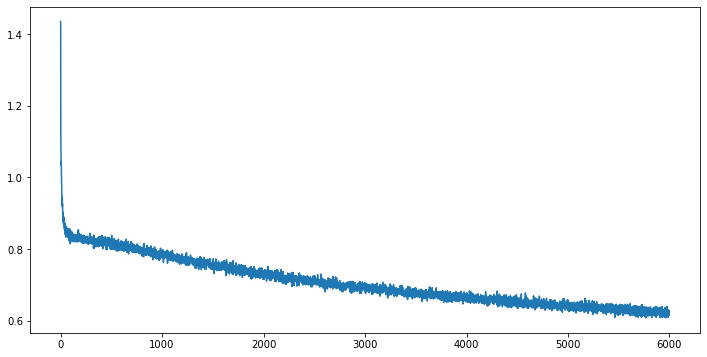

In [32]:
fig = plt.figure(figsize=(12,6))
steps = range(len(Proj_losses))
y = np.array(Proj_losses)
plt.plot(steps,y)
plt.show

In [ ]:
np.array(output[3,256-160:].detach().cpu(), dtype = np.int32)

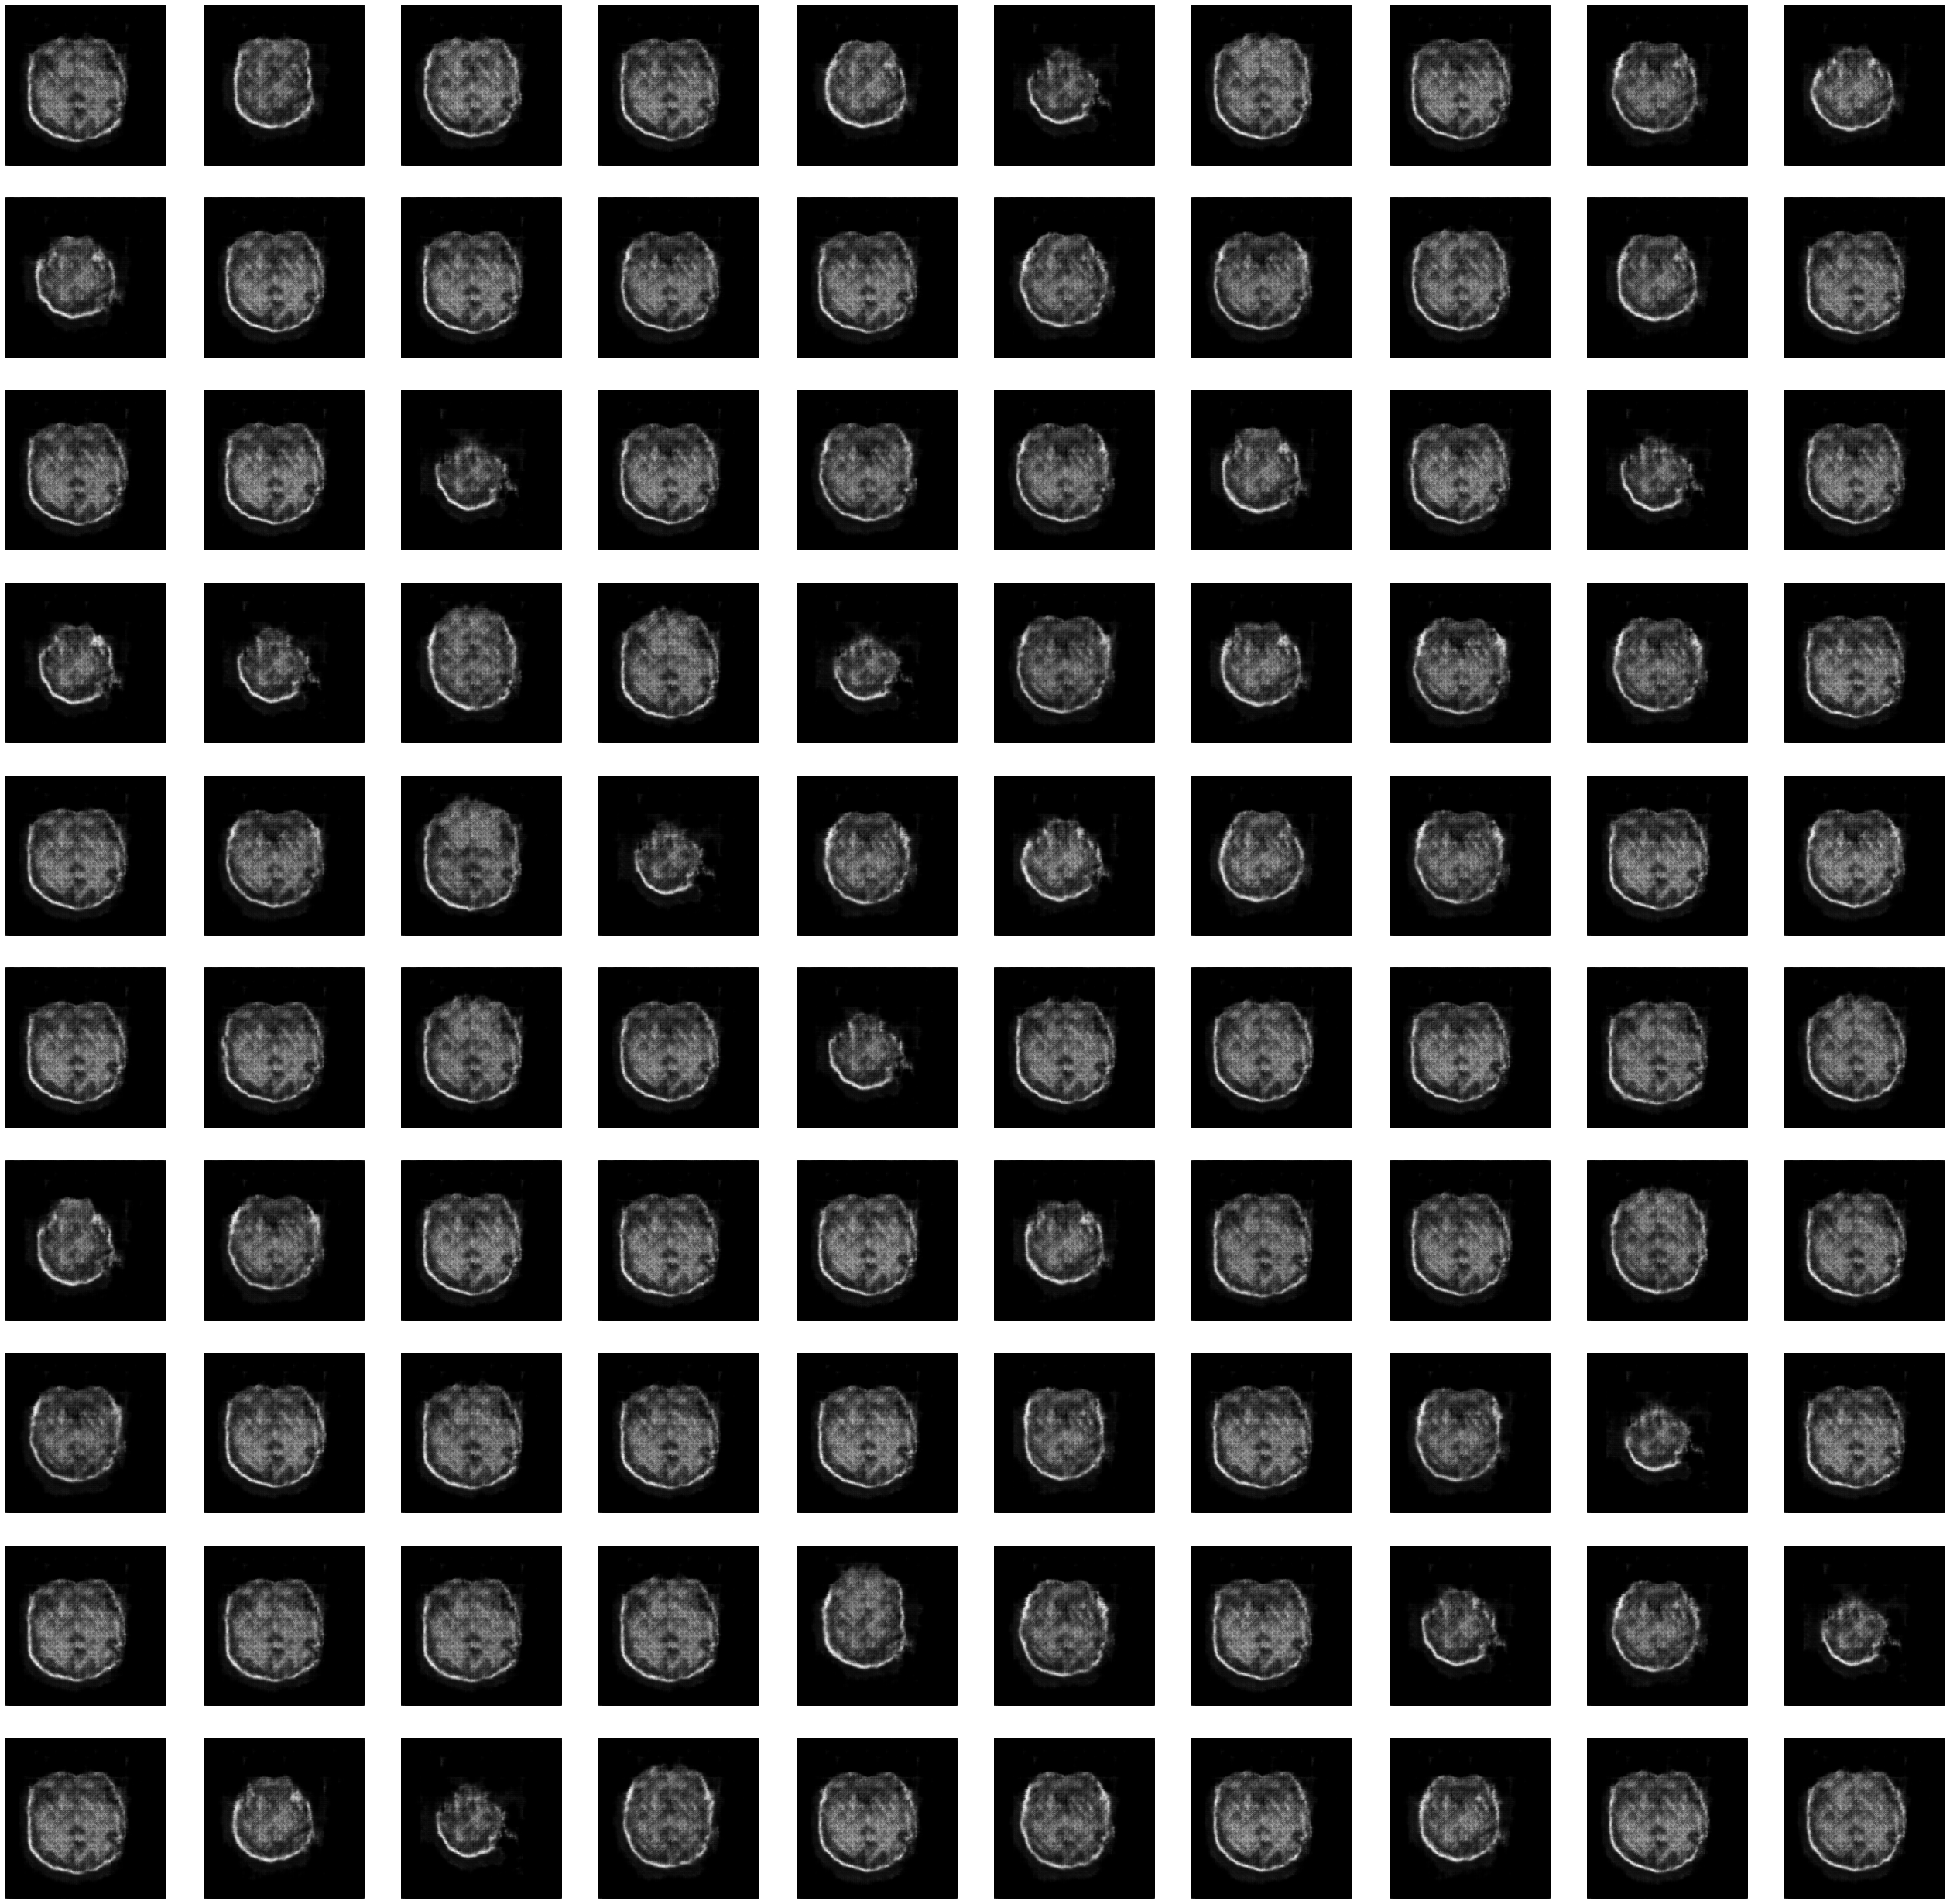

In [34]:
batch_size = 100

noise_g, cont_codes_g = generate_latent_points(latent_dim, n_code_vec, batch_size)
noise_g = noise_g.to(DEVICE)
fake_data_g, _ = generate_fake_samples(g_model, noise_g, batch_size)
fake_data_g = fake_data_g.to(DEVICE)
inp = fake_data_g.detach()
output = proj_model(inp)
fake_data, _ = generate_fake_samples(g_model, output.detach(), batch_size)
fake_data = fake_data.to(DEVICE)
fig = plt.figure(figsize=(45,45))
for i in range(batch_size):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(np.array(fake_data.detach().cpu())[i][0,:,:],cmap = 'gray')
plt.show()